# Project 2 : Hidden Markov models and optimal control
Authors : Simon Vandergooten and Clémence Vandamme.

In this second project, you will implement a Hidden Markov Model with 3 states and apply to your posterior probabilities optimal control. In other words, based on your knowledge and uncertainties, you will decide the optimal actions you need to take in any situation.

## Context :
The belgian government is trying to develop a new strategy to differentiate between patients with hypertension and those with hypotension in order to help preventing fainting and cardiac arrest.

Patients can be in one of the three following states : healthy, hypertension or hypotension. The patient's health status is represented by the vector $S$, where each value $s_t$ represents the patient's status in day $t$. The government also provides you the transition probabilities between each state, based on data from the national public health department.

You received the blood pressure measurements of 5 patients for 150 days. Those measurements are made with a new state-of-the-art tool. However, the design of this tool is not perfect (yet) and the measurements are very imprecise. Based on these data, you are asked to provide the probabilities of each state (hypertension, hypotension and healthy) at each timestep for the 5 patients.

Furthermore, two drugs are available on the market. One aims to lower the blood pressure, the other increases it. At each moment, you need to determine if you should take a drug and which one. However, take into account that these drugs have a cost and that taking a drug when healthy represents a risk to make the situation worse.  

## Practical information:
### HMM

The following graph sums up the different states and their transition probabilities. **The initial state is healthy**.

<img alt='Solution hint' align='center' width=450 height=450 src=https://raw.githubusercontent.com/svandergoote/LGBIO2060-2021/master/Solutions/Projet2_2022.png>


### Measurements

Concerning the measurements $m_t$, the systolic blood pressure levels are distributed as follow:

* $m_t \sim \mathcal{N}$(120, $\sigma_{healthy}^2$) if $s_t$ = 'healthy'.

* $m_t \sim \mathcal{N}$(160, $\sigma_{hyper}^2$) if $s_t$ = 'hyper'.

* $m_t \sim \mathcal{N}$(80, $\sigma_{hypo}^2$) if $s_t$ = 'hypo'.

Where $\sigma_{healthy}, \, \sigma_{hyper}, \, \sigma_{hypo}=27, \, 30\, , 28$  are the measurement noise related to the new tool.



### Potential actions and their effects

Each day, you have 3 options:
- Take a drug A
    - It has 80% chances to **lower** your tension to 120 if you suffer from **hypertension**. (Therefore, 20% chances to have no effect).
    - It has 40% chance to **lower** your tension to 80 if you were **healthy**.
    - It has **no effect** if you suffer from **hypotension**.

- Take a drug B
    - It has 80% chances to **increase** your tension to 120 if you suffer from **hypotension**.
    - It has 40% chances to **increase** your tension to 160 if you were **healthy**.
    - It has **no effect** if you suffer from **hypertension**.

- Do nothing: no effect on your blood pressure in any state.

VERY IMPORTANT NOTE : The action has no impact on the state transition and the state itself. It should only be the most appropropriate action based on your belief about the state. For example, if a patient has hypertension today, takes the drug A and recovers a normal tension; tomorrow's state will be based on the fact that the patient had hypertension today. In other words, you can first estimate all states, then compute independently the most appropriate actions.


### Utility and cost
Utility values associated to blood pressure:
- 120 mmHg : U = +2
- 160 mmHg : U = -2 (risk of heart attack)
- 80 mmHg : U = -1 (risk of fainting)

Costs:
- Drug A : 2
- Drug B : 2







## Guidelines

**READ THIS PART CAREFULLY**

For the first part of the project, you are asked to estimate the posterior probability of each state at any time, based on the measurements vector M and on the transition probabilities. M contains 150 measurements. Then, graphically represent the evolution of these probabilities. The way you plot these data is up to you, make it readable and interpretable (you do not necessarily have to represent all the time steps).


In the second part, determine the policy you will follow at each time step to choose the optimal action. Based on this policy, return the vector of actions taken for the given data. A policy must be optimal in the sense that it maximizes the benefit (utility) and minimizes the cost. It simply consists in setting a threshold on your posterior belief. For example, "*if I have more than 65% probability to have hypertension, I will take drug A*" is a policy. We give you the 100 first true states to test different policies (i.e, different thresholds) and determine which one is the best. Indeed, with the true states, you can determine the impact of your actions and compute both the benefit and the cost.
After finding your optimal policy, you can look at the actions chosen for your measures for which you do not have the true states (i.e the last 50 measurements).


Finally, discuss the impact of some relevant parameters of the model. For exemple, what do you observe in the policy and selected actions if the cost of both drugs increase ? Also, do the thresholds depends on the subjects ? Why ?



### To sum up:

1) Create your HMM and compute the posterior probabilities associated to each state based on the measurements.

2) Graphically represent the evolution of the posteriors.

3) Define an optimal policy (this answer must appear clearly).  

4) Based on your policy, determine the drug to take at each time step for the given data.

5) Discuss the impact of the parameters of the model on the policy and the resulting actions.


### Data:

- The vector $S$ containing the 100 first hidden states $s_t$:
  * $s_t$ = 'healthy' if the patient's state is healthy for day $t$
  * $s_t$ = 'hyper' if the patient's state is hypertension for day $t$
  * $s_t$ = 'hypo' if the patient's state is hypotension for day $t$

  It must be only used to determine the optimal policy. **It cannot be used for the HMM**.

- The vector $M$ containing 150 measurements $m_t$. It is a vector of scalars.

### Submission
Like for the first project, you must submit your notebook with all your answers.

The **deadline is the Thurday 30 November 22:00**. Name your notebook as follow : "LGBIO2060_Projet2_Grxx".

Don't forget to register for a timeslot for the oral evaluation.

# Project 2: Group 5
---
**Modelling of biological systems**

👥 Authors: Gabriel de Morais and Gabriela Ishikawa

## 1. Create your HMM and compute the posterior probabilities associated to each state based on the measurements.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

file_path = 'M.csv'

# Data from CSV file - 4 rows, one for each patient
M = pd.read_csv('M.csv').values
S = pd.read_csv('S_training.csv').values

# M[:,0] and S[:,0] is not a value 
M = np.delete(M, 0, axis=1)
S = np.delete(S, 0, axis=1)

In [6]:
# Set parameters
means = np.array([120, 160, 80])     # healthy, hyper, hypo

# Initial state = 'healthy'
start_proba = np.array([1, 0, 0])

# Transition matrix
T = np.array([[0.3, 0.4, 0.3], [0.35, 0.5, 0.15], [0.6, 0.1, 0.3]])

# Variances
var = np.array([27*27, 30*30, 28*28])

nsteps = 150

In [7]:
def sample(means, var, S):

  #Initialize measurements vector M
  M = np.zeros(len(S))

  #Calculate measurements conditioned on the latent states (Hint: np.random.normal)
  for i in range(len(S)):
    if S[i] == 120:
      M[i] = np.random.normal(means[0], np.sqrt(var[0]))
    elif S[i] == 160:
      M[i] = np.random.normal(means[1], np.sqrt(var[1]))
    elif S[i] == 80:
      M[i] = np.random.normal(means[2], np.sqrt(var[2]))

  return M

In [8]:
def compute_likelihood(means, var, M):

  p_healthy = norm(loc=means[0], scale=np.sqrt(var[0]))
  p_hyper = norm(loc=means[1], scale=np.sqrt(var[1]))
  p_hypo = norm(loc=means[2], scale=np.sqrt(var[2]))
  L = np.stack([p_healthy.pdf(M), p_hyper.pdf(M), p_hypo.pdf(M)], axis=0)
  if L.size == 3:
    L = L.flatten()

  return L

In [9]:
def one_step_update(T, posterior_tm1, M_t, means, var):

  # Calculate predictive probabilities (prior)
  prediction = posterior_tm1 @ T

  #Get the likelihood (Hint: Use compute_likelihood)
  likelihood = compute_likelihood(means, var, M_t)

  # Calculate posterior
  posterior_t = prediction * likelihood
  #Normalize
  posterior_t /= np.sum(posterior_t)

  return prediction, likelihood, posterior_t

In [10]:
def simulate_forward_inference(means, var, T, startProba, N, data):

  #Initialize arrays
  predictive_probs = np.zeros((N,3))
  likelihoods = np.zeros((N,3))
  posterior_probs = np.zeros((N,3))

  #Start with the first element
  predictive_probs[0,:] = startProba
  likelihoods[0,:] = compute_likelihood(means, var, data[0])
  posterior = predictive_probs[0,:] * likelihoods[0,:]
  posterior /= np.sum(posterior)
  posterior_probs[0,:] = posterior

  #Then iterate for the rest of the N elements
  for t in range(1, N):
    prediction, likelihood, posterior = one_step_update(T, posterior_probs[t-1], data[t], means, var) 
    # normalize and add to the list
    posterior /= np.sum(posterior)
    predictive_probs[t,:] = prediction
    likelihoods[t,:] = likelihood
    posterior_probs[t,:] = posterior

  return predictive_probs, likelihoods, posterior_probs

predictive_probs, likelihoods, posterior_probs = simulate_forward_inference(means, var, T, start_proba, nsteps, M[0])


In [30]:
# caculate posterior for each patiente

posteriors = [[], [], [], [], []]
for i in range(5):
    _, _, posteriors[i] = simulate_forward_inference(means, var, T, start_proba, nsteps, M[i])

## Graphical Evolution

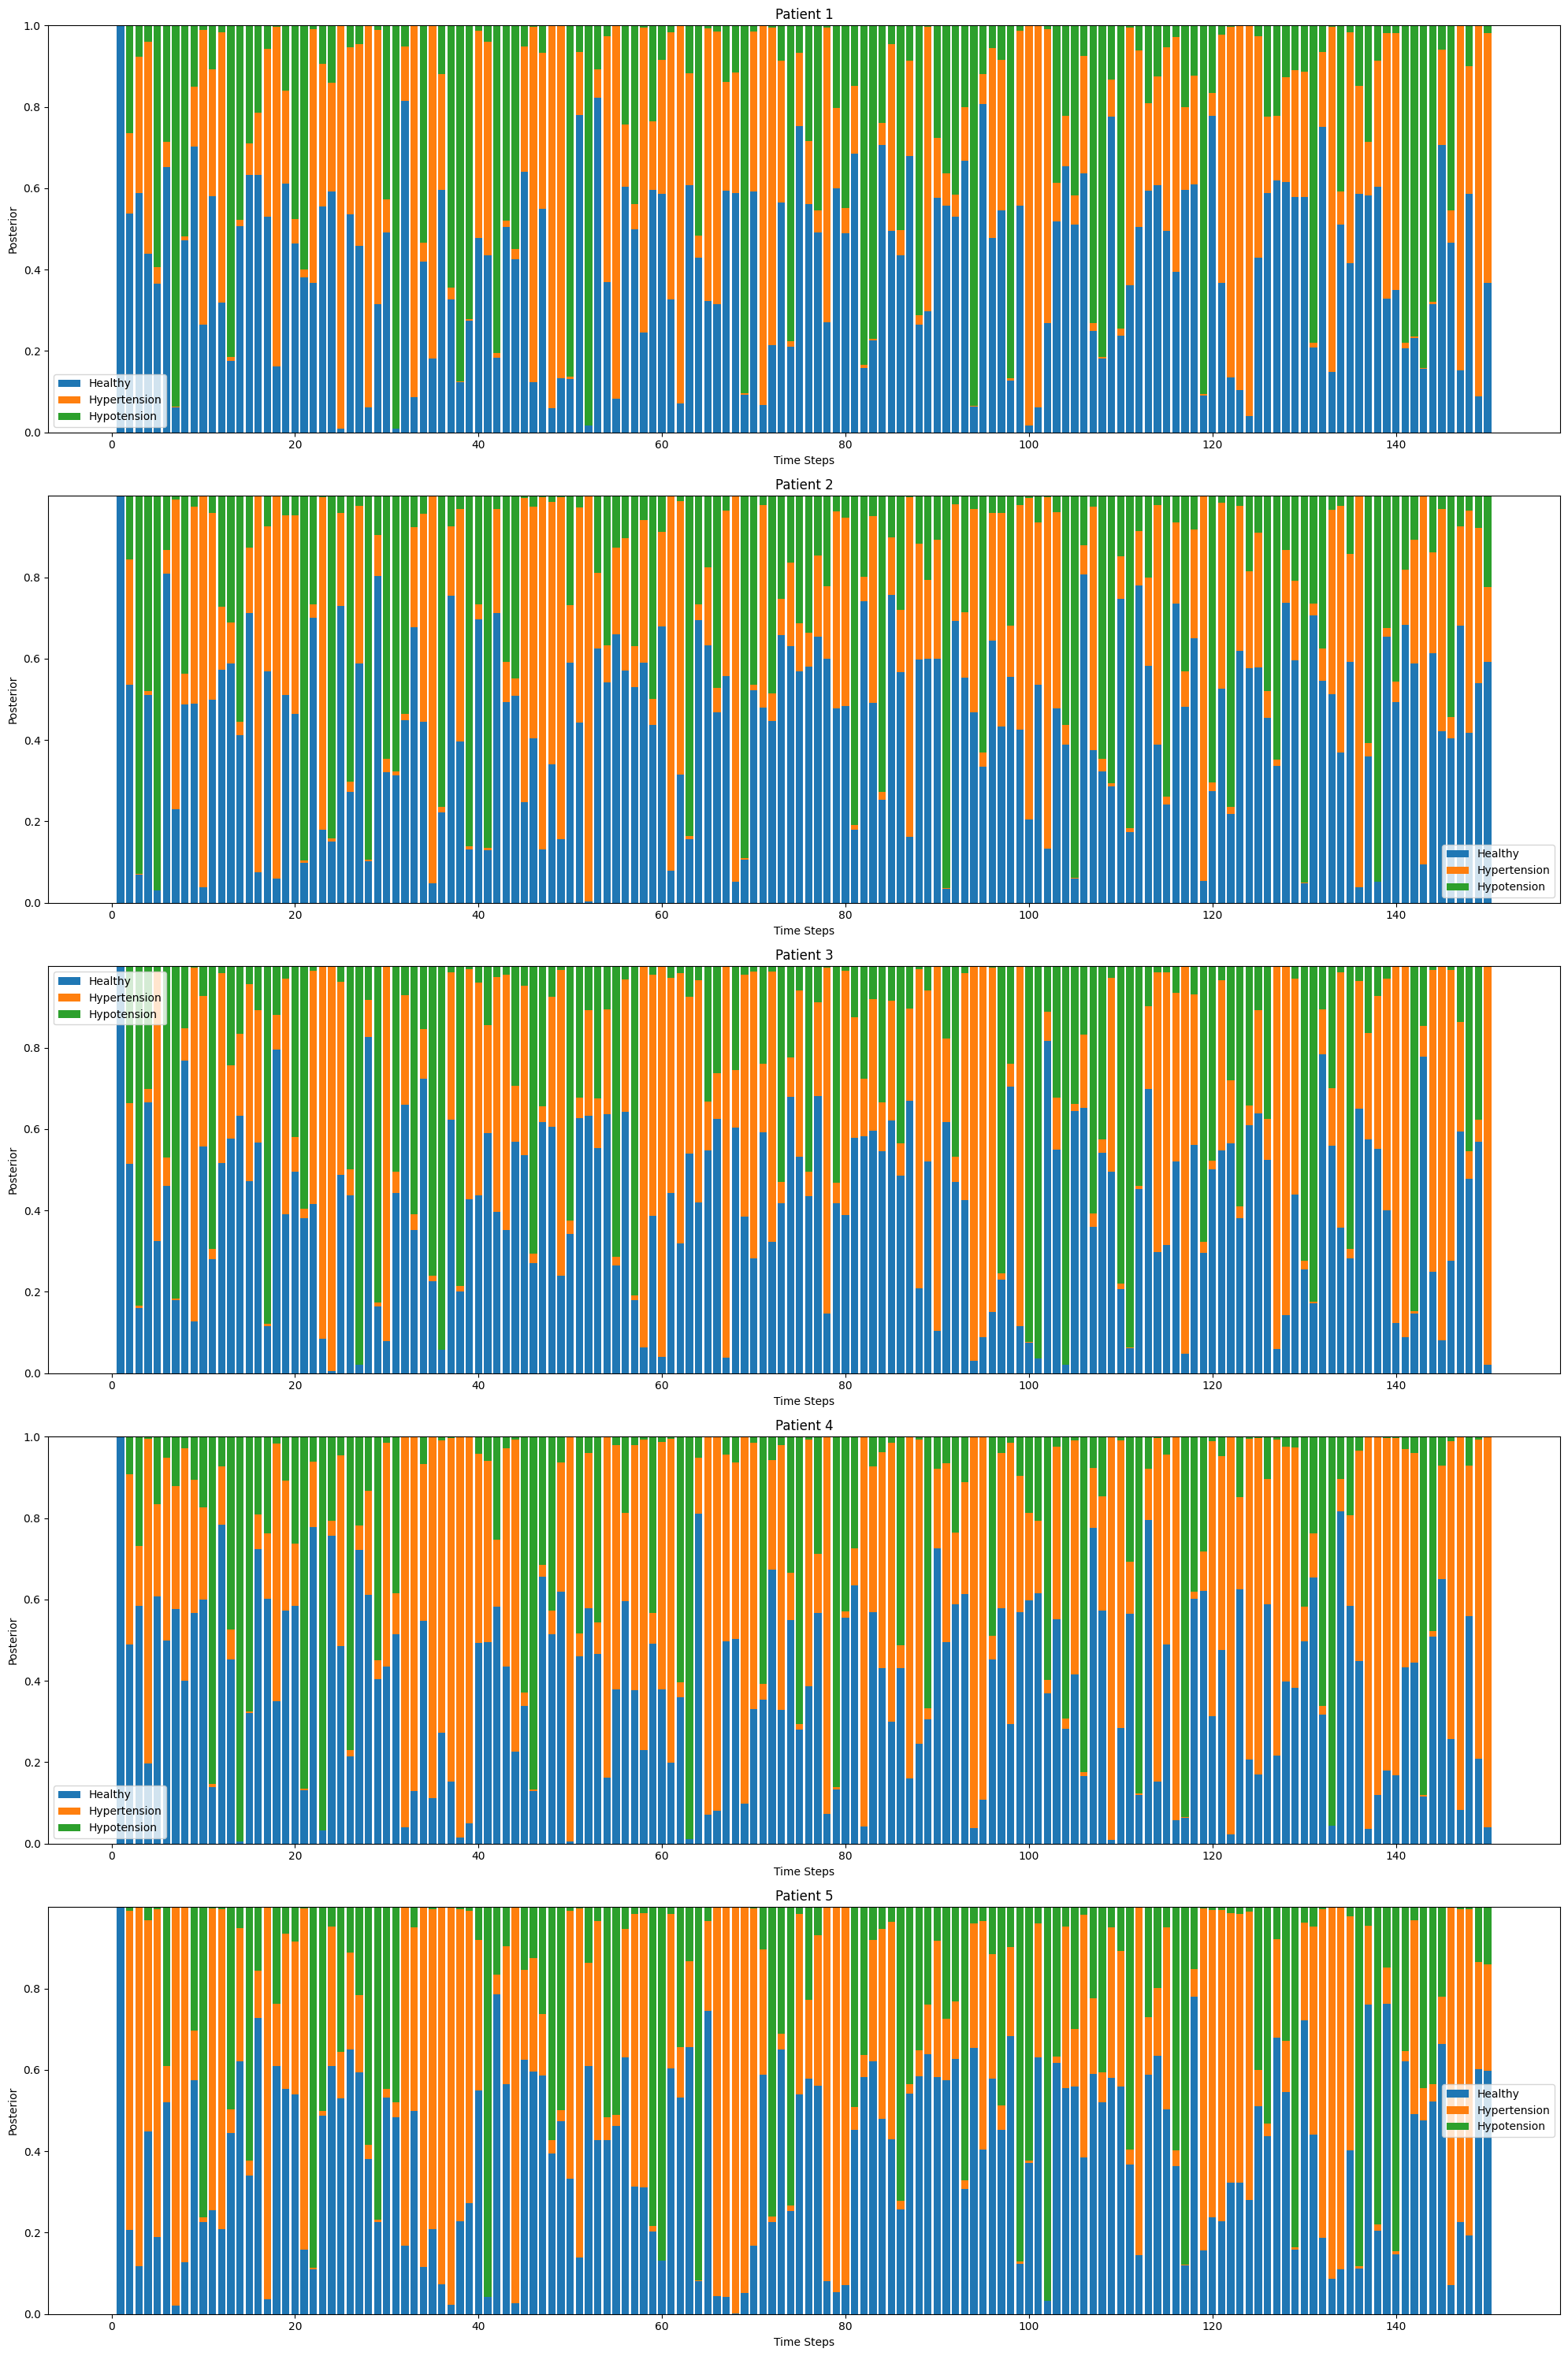

In [31]:
# Assuming you have posterior_probs for each patient (posterior_probs_1, posterior_probs_2, posterior_probs_3, posterior_probs_4)

# Create a list of posterior probabilities for each patient
posterior_probs_list = posteriors

# Assuming vector is defined as in your previous code
vector = np.linspace(1, 150, 150)

# Create four subplots for each patient's posterior probabilities
fig, axs = plt.subplots(5, 1, figsize=(20, 30))  # Create a 4x1 grid of subplots

# Iterate over each patient's posterior probabilities
for i, posterior_probs in enumerate(posterior_probs_list):
    ax = axs[i]  # Get the corresponding axis for the current subplot
    
    # Plot posterior probabilities for the current patient
    ax.bar(vector, posterior_probs[:,0], label="Healthy")
    ax.bar(vector, posterior_probs[:,1], bottom=posterior_probs[:,0], label="Hypertension")
    ax.bar(vector, posterior_probs[:,2], bottom=posterior_probs[:,0] + posterior_probs[:,1], label="Hypotension")
    
    ax.legend()  # Show legend for each subplot
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Posterior')
    ax.set_title(f'Patient {i+1}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [33]:
posteriors_M = [[], [], [], [], []]
for i in range(5):
    new_M = np.zeros(150)

    for j in range(len(posterior_probs)):
        new_M[j] = np.random.choice([120, 160, 80], p=posterior_probs[j])

    new_M = sample(means, var, new_M)
    new_M[0] = 120
    posteriors_M[i] = new_M

<BarContainer object of 150 artists>

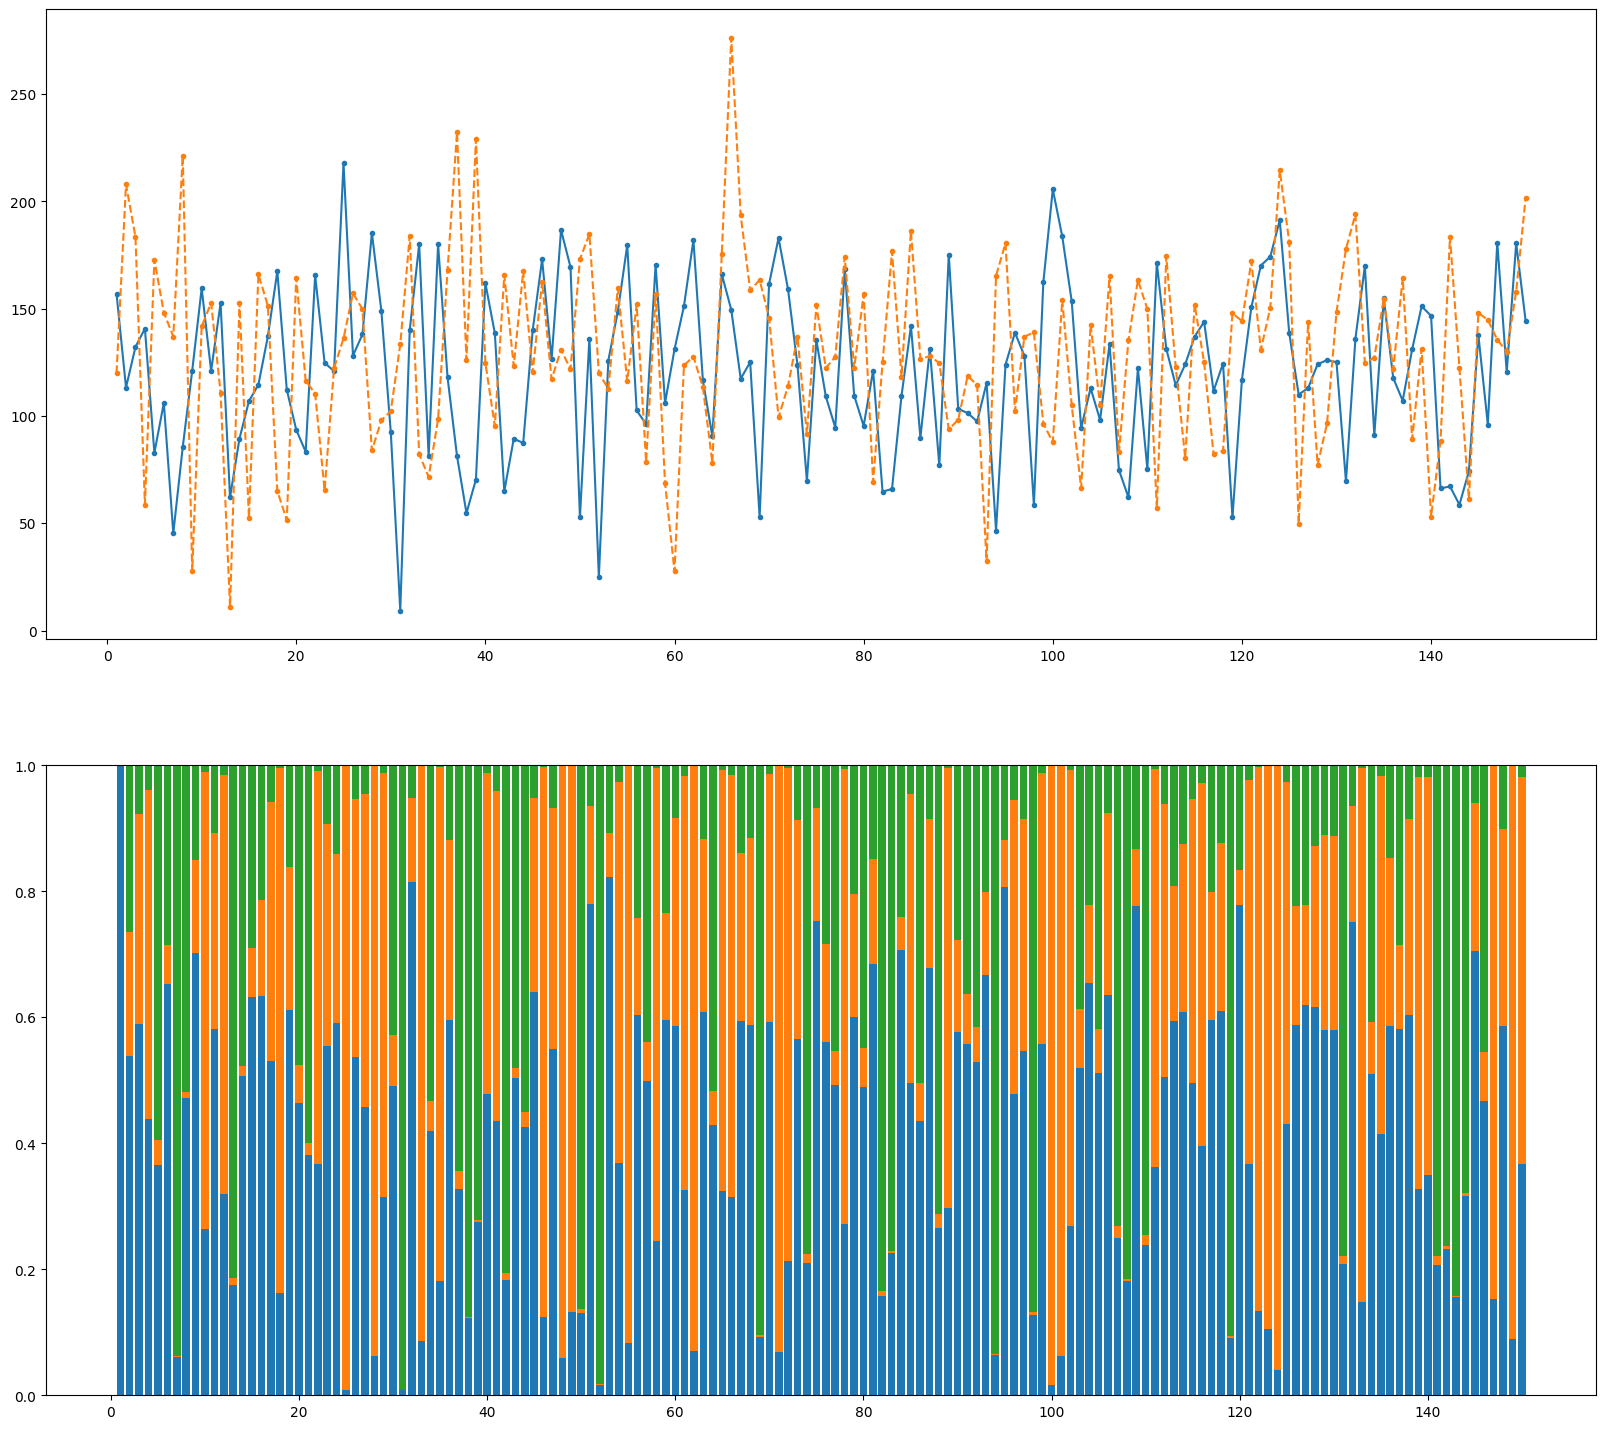

In [37]:
#  Patient 1 plt
posterior_probs = posteriors[0]
measurements = M[0]
post_M = posteriors_M[0]
vector = np.linspace(1, len(posterior_probs), len(posterior_probs))
fig, axs = plt.subplots(2, 1, figsize=(20, 18))

# measurements x time steps
axs[0].plot(vector, measurements, marker='.', linestyle='-')
axs[0].plot(vector, post_M, marker='.', linestyle='--')

# Plot posterior probabilities for the current patient
axs[1].bar(vector, posterior_probs[:,0], label="Healthy")
axs[1].bar(vector, posterior_probs[:,1], bottom=posterior_probs[:,0], label="Hypertension")
axs[1].bar(vector, posterior_probs[:,2], bottom=posterior_probs[:,0] + posterior_probs[:,1], label="Hypotension")



## Optimal Policy

### Potential actions and their effects

Each day, you have 3 options:
- Take a drug A
    - It has 80% chances to **lower** your tension to 120 if you suffer from **hypertension**. (Therefore, 20% chances to have no effect).
    - It has 40% chance to **lower** your tension to 80 if you were **healthy**.
    - It has **no effect** if you suffer from **hypotension**.

- Take a drug B
    - It has 80% chances to **increase** your tension to 120 if you suffer from **hypotension**.
    - It has 40% chances to **increase** your tension to 160 if you were **healthy**.
    - It has **no effect** if you suffer from **hypertension**.

- Do nothing: no effect on your blood pressure in any state.

VERY IMPORTANT NOTE : The action has no impact on the state transition and the state itself. It should only be the most appropropriate action based on your belief about the state. For example, if a patient has hypertension today, takes the drug A and recovers a normal tension; tomorrow's state will be based on the fact that the patient had hypertension today. In other words, you can first estimate all states, then compute independently the most appropriate actions.


### Utility and cost
Utility values associated to blood pressure:
- 120 mmHg : U = +2
- 160 mmHg : U = -2 (risk of heart attack)
- 80 mmHg : U = -1 (risk of fainting)

Costs:
- Drug A : 2
- Drug B : 2

In [ ]:
# posterior is fish_state
# utility is the reward of the action and each drug (action) has a cost > need to maximize the total of this points
# M is loc 

# find a policy > define a threshold > if your belief is lower, change state

# low_rew_prob - prob de pegar o peixe se estiver do lado errado
# high_rew_prob - prob de pegar o peixe se estiver do lado certo
# drug A: se hypertension > 80% de chance de ficar healthy e se healthy > 40% de chance de ficar hypo e se hypo > nao altera, mantem hypo
# drug B: se hypotension > 80% healthy, se healthy > 40% hyper e se hyper, mantém hyper
# no drug: mantém no estado

# policy
# tenho meu belief to estado atual (posterior) > se essa belief ta acima de um threshold entao fazer a ação correspondente (sempre comparar healthy - o que eu acho)
# dada a ação pego o estado atual S (100 primeiros eu tenho) e a prob do efeito > computo a utility e o cost da action
# conseguir achar um com a menor soma (optimal policy) - consigo calcular para os primeiros 100 casos

# pensar na estratégia para achar a melhor policy

In [ ]:
threshold = 0.6

def policy(threshold, posterior):
    # action - 0: drug A, 1: drug B, 2: do nothing

    # todo: optimize
    if posterior[1] > threshold:
        # hypertension
        action = 0
    elif posterior[2] > threshold:
        action = 1
    else:
        action = 2

    return action

In [ ]:
# state action x state effect
a_effect = np.array([[0.6, 0, 0.4], [0.8, 0.2, 0], [0, 0, 1]])
b_effect = np.array([[0.6, 0.4, 0], [0, 1, 0], [0.8, 0, 0.2]])
nodrug_effect = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])

utility = np.array([2, -2, -1])

def compute_values(state, action):

    if state == 'healthy':
        s = 0
    elif state == 'hyper':
        s = 1
    elif state == 'hypo':
        s = 2

    if action == 0:
        # drug a
        value = np.random.choice(utility, p=a_effect[s,:]) - 2
    elif action == 1:
        # drug b
        value = np.random.choice(utility, p=b_effect[s,:]) - 2
    elif action == 2:
        # nothing
        value = np.random.choice(utility, p=nodrug_effect[s,:])

    return value